In [1]:
import glob
import json
import os
import random as rnd
import shutil

import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow import keras
from tqdm import tqdm

from src.test_utils import (
    choose_100,
    load_submission,
    pairwise_distances,
    TestGenerator,
    eval_submission
)
from _data.artist_data.ny_baseline import inference, get_ranked_list
from _data.artist_data.ny_baseline import eval_submission as ev_sub

from src.utils import make_callbacks, plot_history

InteractiveShell.ast_node_interactivity = "all"

In [2]:
class CFG:
    def __init__(
        self,
    ):
        self.seed = 39
        self.batch_size = 32
        self.img_size = (512, 60)
        self.crop = self.img_size < (512, 81)
        self.n_chanels = 1
        self.n_folds = 8
        self.fold = 0
        self.norm = False
        self.pos_label = 0
        self.n_blocks = 4
        self.emb_len = 1024
        self.kernel_size = (5, 2)
        self.act_fn = "relu"
        self.batch_norm = False
        self.n_epochs = 300
        self.input_shape = (self.img_size[0], self.img_size[1], self.n_chanels)

In [3]:
cfg = CFG()

In [4]:
root_dir = "/app/_data/artist_data/"
mod_dir = f"/app/_data/artist_data/models/test_arch/tripl_semi_hard_8_{cfg.fold}/"
mod_dir

'/app/_data/artist_data/models/test_arch/tripl_semi_hard_8_0/'

In [5]:
train = pd.read_csv(os.path.join(root_dir, "train.csv"))
train = train[train["artistid_count"] != 1].reset_index(drop=True)
test = pd.read_csv(os.path.join(root_dir, "test_meta.tsv"), sep="\t")
test["path"] = test["archive_features_path"].apply(
    lambda x: os.path.join(root_dir, "test_features", x)
)

## train_val_split

In [6]:
gkf = StratifiedGroupKFold(n_splits=cfg.n_folds, shuffle=True, random_state=cfg.seed)
for n, (train_ids, val_ids) in enumerate(
    gkf.split(
        X=train[["artistid", "artistid_count"]],
        y=train["artistid_count"],
        groups=train["artistid"],
    )
):
    train.loc[val_ids, "fold"] = n

In [7]:
train_df = train[train["fold"] != cfg.fold].reset_index(drop=True)
val_df = train[train["fold"] == cfg.fold].reset_index(drop=True)

## DataGenerator

In [8]:
class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        data,
        img_size,
        batch_size=32,
        norm=False,
        n_chanels=1,
        shuffle=True,
        transpose=True,
    ):
        self.data = data.reset_index(drop=True)
        self.img_size = img_size
        self.batch_size = batch_size
        self.norm = norm
        self.n_chanels = n_chanels
        self.shuffle = shuffle
        self.artist_ids = self.data["artistid"].unique().tolist()
        self.default_img_size = (512, 81)
        self.artis2path = self.data.groupby("artistid").agg(list)["path"].to_dict()
        self.path2artist = self.data.set_index("path")["artistid"].to_dict()
        self.paths = self.data["path"].tolist()
        self.transpose = transpose
        if self.shuffle:
            np.random.shuffle(self.paths)

    def __len__(self):
        return self.data.shape[0] // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.artist_ids)

    def load_img(self, path):
        img = np.load(path).astype("float32")
        if self.norm:
            img -= img.min()
            img /= img.max()
        if self.img_size < self.default_img_size:
            wpad = (img.shape[1] - self.img_size[1]) // 2
            img = img[:, wpad : wpad + self.img_size[1]]
        if img.shape != self.img_size:
            wpad = self.img_size[1] - img.shape[1]
            wpad_l = wpad // 2
            wpad_r = wpad - wpad_l
            img = np.pad(
                img,
                pad_width=((0, 0), (wpad_l, wpad_r)),
                mode="constant",
                constant_values=0,
            )
        if self.transpose:
            img = img.transpose(1, 0)
        img = np.expand_dims(img, -1)
        if self.n_chanels == 3:
            img = np.concatenate([img, img, img], -1)
        return img

    def __getitem__(self, batch_ix):
        artist_ids = rnd.sample(self.artist_ids, self.batch_size // 4)
        paths = (
            self.data.query("artistid in @artist_ids").sample(frac=1)["path"].tolist()
        )
        if len(paths) >= self.batch_size:
            batch_paths = rnd.sample(paths, self.batch_size)
        else:
            paths.extend(rnd.sample(self.paths, self.batch_size - len(paths)))
            batch_paths = paths
        imgs, labels = [], []
        for i in range(self.batch_size):
            path = batch_paths[i]
            imgs.append(self.load_img(path))
            labels.append(self.path2artist[path])
        imgs = np.array(imgs)
        labels = np.array(labels)
        return imgs, labels

In [9]:
train_gen = DataGenerator(
    data=train_df,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
    shuffle=True,
    transpose=False,
)
val_gen = DataGenerator(
    data=val_df,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
    shuffle=False,
    transpose=False,
)

In [10]:
imgs, labels = train_gen.__getitem__(0)
imgs.shape
labels

(32, 512, 60, 1)

array([ 1662, 14590,  3345, 16985, 16985,  3345,  3345,  1662,  1662,
       12410,  4704, 17691, 16985,  3345,  3345, 17900, 16985, 17691,
        4704, 16985,  1662, 17691,  4704, 16985, 16985,  4704, 12410,
        4704,  1662, 14590, 17900,  4704])

In [11]:
def embNet(input_shape, dropout_rate=0.1, embedding_len=1024, activation_fn="relu"):
    base_model = keras.applications.MobileNetV3Small(
        input_shape=input_shape,
        alpha=1.0,
        dropout_rate=dropout_rate,
        include_top=False,
        weights=None,
        pooling=None,
        include_preprocessing=False,
    )
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), name="max_pool_emb")(
        base_model.output
    )
    x = keras.layers.Flatten(name="flatten")(x)
    x = keras.layers.Dense(embedding_len, activation=None, name="dense_1")(x)
    x = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name="l2norm")(x)
    embedding_net = keras.Model(inputs=base_model.input, outputs=x, name="embedding")
    return embedding_net

In [12]:
# def embNet(
#     input_shape,
#     kernel_size=3,
#     dropout_rate=0.1,
#     embedding_len=1024,
#     activation_fn="relu",
#     padding="valid",
#     dense_activation="relu",
# ):
#     base_model = tf.keras.models.Sequential(
#         [
#             keras.layers.Conv2D(
#                 filters=1,
#                 kernel_size=kernel_size,
#                 activation=activation_fn,
#                 input_shape=input_shape,
#                 padding=padding,
#                 name="conv_1",
#             ),
#             keras.layers.Conv2D(
#                 filters=1,
#                 kernel_size=kernel_size,
#                 activation=activation_fn,
#                 padding=padding,
#                 name="conv_2",
#             ),
#             keras.layers.Dropout(rate=dropout_rate, name="dropout1"),
#             keras.layers.MaxPooling2D(
#                 pool_size=(2, 2), strides=1, padding="same", name="max_1"
#             ),
#             keras.layers.Conv2D(
#                 filters=1,
#                 kernel_size=kernel_size,
#                 activation=activation_fn,
#                 padding=padding,
#                 name="conv_3",
#             ),
#             keras.layers.Conv2D(
#                 filters=1,
#                 kernel_size=kernel_size,
#                 activation=activation_fn,
#                 padding=padding,
#                 name="conv_4",
#             ),
#             keras.layers.Dropout(rate=dropout_rate, name="dropout2"),
#             keras.layers.MaxPooling2D(
#                 pool_size=(2, 2), strides=1, padding="same", name="max_2"
#             ),
#             keras.layers.Conv2D(
#                 filters=1,
#                 kernel_size=kernel_size,
#                 activation=activation_fn,
#                 padding=padding,
#                 name="conv_5",
#             ),
#             keras.layers.Conv2D(
#                 filters=1,
#                 kernel_size=kernel_size,
#                 activation=activation_fn,
#                 padding=padding,
#                 name="conv_6",
#             ),
#             keras.layers.Dropout(rate=dropout_rate, name="dropout3"),
#             keras.layers.MaxPooling2D(
#                 pool_size=(2, 2), strides=1, padding="same", name="max_3"
#             ),
#             keras.layers.Flatten(name="flatten_base"),
#             keras.layers.Dense(embedding_len, activation=None, name="dense_base"),
            
#         ]
#     )
#     x = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name="l2norm")(base_model.output)
#     embedding_net = keras.Model(inputs=base_model.input, outputs=x, name="embedding")
#     return embedding_net

In [13]:
embedding_net = embNet(
    input_shape=cfg.input_shape,
    dropout_rate=0.1,
    embedding_len=512,
    activation_fn="relu",
)

In [14]:
embedding_net.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001), loss=tfa.losses.TripletSemiHardLoss()
)

In [15]:
calbacks = make_callbacks(
    path=mod_dir, monitor="val_loss", mode="min", reduce_patience=10, stop_patience=55
)

In [16]:
history = embedding_net.fit(
    x=train_gen, validation_data=val_gen, epochs=500, callbacks=calbacks
)

Epoch 1/500
4573/4573 [==============================] - ETA: 0s - loss: 0.8601
Epoch 1: val_loss improved from inf to 0.98158, saving model to /app/_data/artist_data/models/test_arch/tripl_semi_hard_8_0/model.h5
4573/4573 [==============================] - 193s 40ms/step - loss: 0.8601 - val_loss: 0.9816 - lr: 1.0000e-04
Epoch 2/500
4573/4573 [==============================] - ETA: 0s - loss: 0.7853
Epoch 2: val_loss improved from 0.98158 to 0.78142, saving model to /app/_data/artist_data/models/test_arch/tripl_semi_hard_8_0/model.h5
4573/4573 [==============================] - 181s 39ms/step - loss: 0.7853 - val_loss: 0.7814 - lr: 1.0000e-04
Epoch 3/500
4572/4573 [============================>.] - ETA: 0s - loss: 0.7538
Epoch 3: val_loss improved from 0.78142 to 0.76519, saving model to /app/_data/artist_data/models/test_arch/tripl_semi_hard_8_0/model.h5
4573/4573 [==============================] - 181s 40ms/step - loss: 0.7538 - val_loss: 0.7652 - lr: 1.0000e-04
Epoch 4/500
4573/457

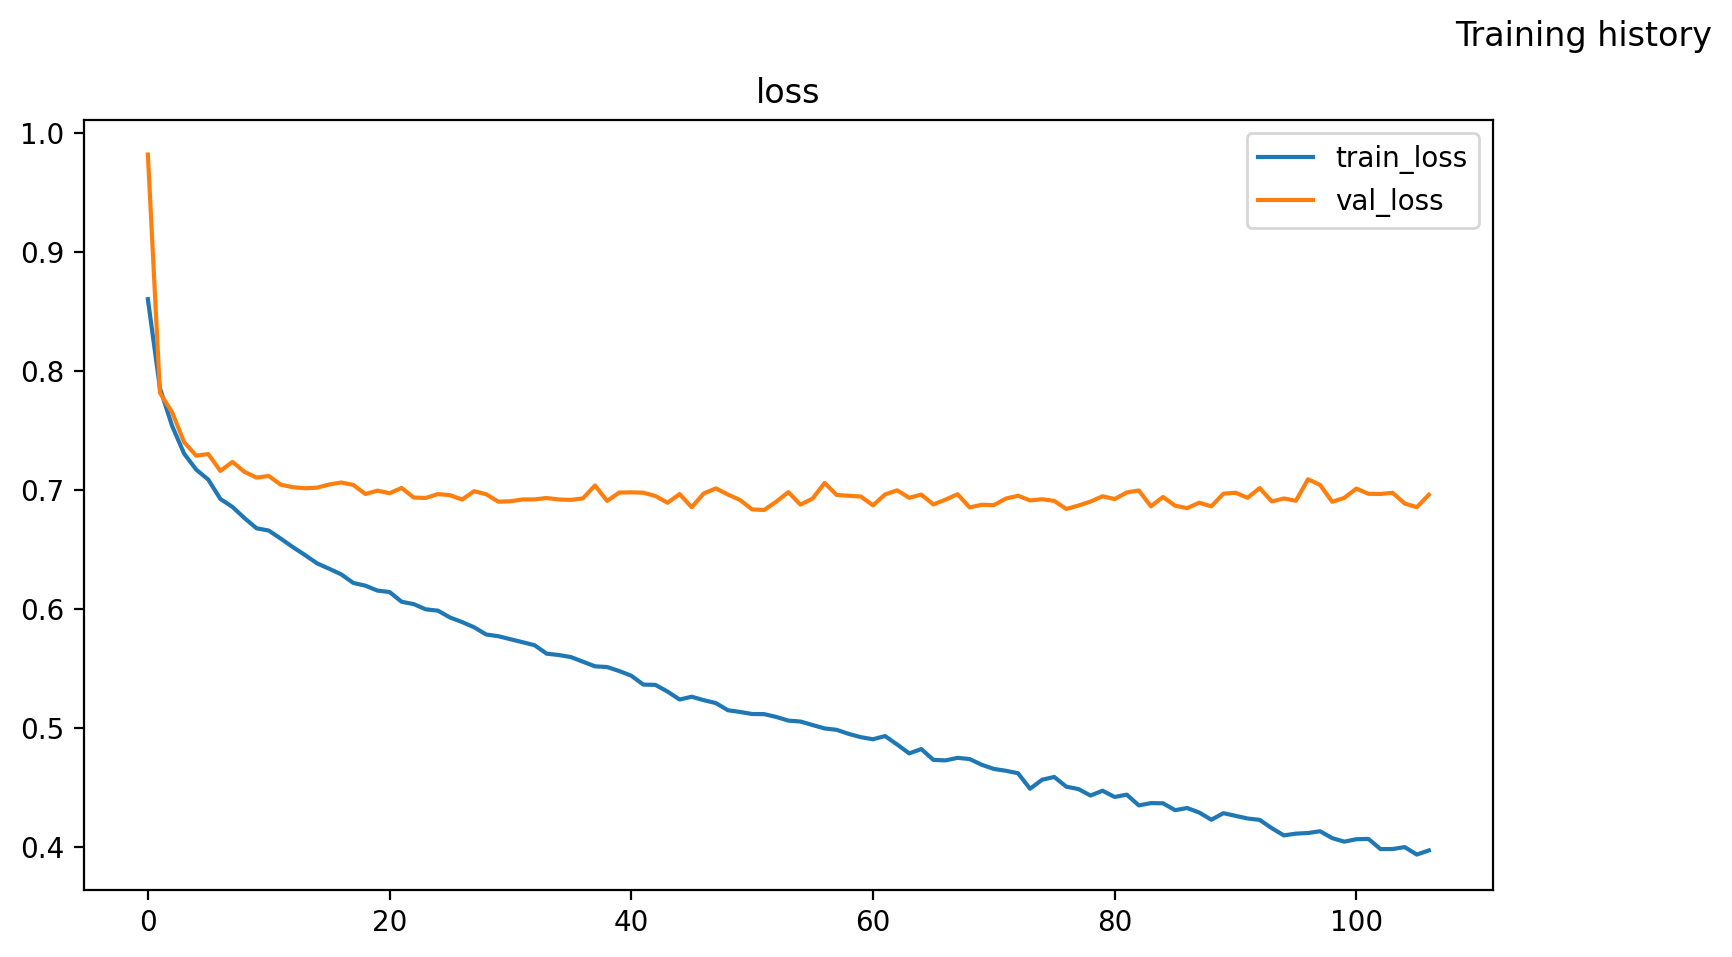

In [17]:
plot_history(history.history)

In [18]:
def save_params(mod_dir, model, history, cfg, loss="constr"):
    train_history = history.history
    min_val_loss = np.min(train_history["val_loss"])

    for k in train_history.keys():
        train_history[k] = list(map(float, train_history[k]))
    model.save(
        os.path.join(mod_dir, f"model_{min_val_loss}.h5"),
    )
    config = {
        "loss": loss,
        "history": train_history,
        "norm": cfg.norm,
        "fold": cfg.fold,
        "model": {
            "eff": False,
            "input_shape": cfg.input_shape,
            "embedding_len": cfg.emb_len,
            "kernel_size": cfg.kernel_size,
            "activation_fn": cfg.act_fn,
            "batch_norm": False,
        },
    }
    with open(os.path.join(mod_dir, "config.json"), "w") as f:
        json.dump(config, f)
    model.save(os.path.join(mod_dir, f"model_{min_val_loss}"), include_optimizer=False)
    print(
        f'min_val_loss = {min_val_loss}, model saved to {os.path.join(mod_dir, f"model_{min_val_loss}")}'
    )

In [19]:
save_params(mod_dir, embedding_net, history, cfg, loss="semihardtripl")

INFO:tensorflow:Assets written to: /app/_data/artist_data/models/test_arch/tripl_semi_hard_8_0/model_0.6830780506134033/assets


INFO:tensorflow:Assets written to: /app/_data/artist_data/models/test_arch/tripl_semi_hard_8_0/model_0.6830780506134033/assets


min_val_loss = 0.6830780506134033, model saved to /app/_data/artist_data/models/test_arch/tripl_semi_hard_8_0/model_0.6830780506134033


In [20]:
val_df

,trackid,artistid,archive_features_path,path,max,min,mean,width,height,artistid_count,fold
0,65359,2,2/9/5/65359.npy,/app/_data/artist_data/train_features/2/9/5/65...,4.282595,0.0,0.382802,81.0,512.0,10,0.0
1,2,2,2/2/0/2.npy,/app/_data/artist_data/train_features/2/2/0/2.npy,4.063169,0.0,0.419038,81.0,512.0,10,0.0
2,12322,2,2/2/2/12322.npy,/app/_data/artist_data/train_features/2/2/2/12...,4.959069,0.0,0.410951,81.0,512.0,10,0.0
3,43036,2,2/6/3/43036.npy,/app/_data/artist_data/train_features/2/6/3/43...,4.691682,0.0,0.372589,81.0,512.0,10,0.0
4,40112,2,2/2/1/40112.npy,/app/_data/artist_data/train_features/2/2/1/40...,7.055604,0.0,0.390513,81.0,512.0,10,0.0
...,...,...,...,...,...,...,...,...,...,...,...
20832,153876,18455,5/6/7/153876.npy,/app/_data/artist_data/train_features/5/6/7/15...,5.924749,0.0,0.441504,81.0,512.0,2,0.0
20833,157014,18465,5/4/1/157014.npy,/app/_data/artist_data/train_features/5/4/1/15...,4.439708,0.0,0.404386,81.0,512.0,2,0.0
20834,166171,18465,5/1/7/166171.npy,/app/_data/artist_data/train_features/5/1/7/16...,4.742024,0.0,0.407784,81.0,512.0,2,0.0
20835,161032,18467,7/2/3/161032.npy,/app/_data/artist_data/train_features/7/2/3/16...,6.289591,0.0,0.315962,81.0,512.0,2,0.0


In [21]:
class TestGenerator(keras.utils.Sequence):
    def __init__(
        self,
        data,
        img_size,
        batch_size=32,
        norm=False,
        n_chanels=1,
    ):
        self.data = data.reset_index(drop=True)
        self.img_size = img_size
        self.batch_size = batch_size
        self.norm = norm
        self.n_chanels = n_chanels
        self.default_img_size = (512, 81)

    def __len__(self):
        return self.data.shape[0] // self.batch_size

    def load_img(self, path):
        img = np.load(path).astype("float32")
        if self.norm:
            img -= img.min()
            img /= img.max()
        if self.img_size < self.default_img_size:
            wpad = (img.shape[1] - self.img_size[1]) // 2
            img = img[:, wpad : wpad + self.img_size[1]]
        if img.shape != self.img_size:
            wpad = self.img_size[1] - img.shape[1]
            wpad_l = wpad // 2
            wpad_r = wpad - wpad_l
            img = np.pad(
                img,
                pad_width=((0, 0), (wpad_l, wpad_r)),
                mode="constant",
                constant_values=0,
            )
        img = np.expand_dims(img, -1)
        if self.n_chanels == 3:
            img = np.concatenate([img, img, img], -1)
        return img

    def __getitem__(self, batch_ix):
        imgs = np.zeros([self.batch_size, *self.img_size, self.n_chanels])

        for i in range(self.batch_size):
            ix = i + self.batch_size * batch_ix
            img = self.load_img(self.data.loc[ix, "path"])
            imgs[i] = img

        return imgs

In [22]:
def choose_100(
    prediction, df, val=True, path_to_save=mod_dir, file_ix=1, n_samples=100
):
    def pairwise_distances_np(array):
        dists = (
            np.sum(np.square(array), axis=1, keepdims=True)
            + np.sum(np.square(np.transpose(array, (1, 0))), axis=0, keepdims=True)
            - 2.0 * np.matmul(array, np.transpose(array, (1, 0)))
        )
        return dists

    dists = pairwise_distances_np(prediction)
    neigh = {}
    with open(os.path.join(path_to_save, f"submission_{file_ix}"), "w") as f:
        for ix in tqdm(range(prediction.shape[0])):
            trackid = df.loc[ix, "trackid"]
            nearest_100 = np.argsort(dists[ix])[: n_samples + 1]
            tracks_100 = df.loc[nearest_100, "trackid"].tolist()
            neigh[trackid] = {"tracks": [x for x in tracks_100 if x != trackid]}
            if val:
                artist_100 = df.loc[nearest_100, "artistid"].tolist()
                neigh[trackid]["artists"] = artist_100
                neigh[trackid]["artistid"] = df.loc[ix, "artistid"]
            f.write(
                "{}\t{}\n".format(
                    trackid,
                    " ".join(list(map(str, tracks_100))),
                )
            )
    return neigh

In [23]:
def position_discounter(position):
    return 1.0 / np.log2(position + 1)


def get_ideal_dcg(relevant_items_count, top_size):
    dcg = 0.0
    for result_indx in range(min(top_size, relevant_items_count)):
        position = result_indx + 1
        dcg += position_discounter(position)
    return dcg


def compute_dcg(query_trackid, ranked_list, track2artist_map):
    query_artistid = track2artist_map[query_trackid]
    dcg = 0.0
    for result_indx, result_trackid in enumerate(ranked_list):
        position = result_indx + 1
        discounted_position = position_discounter(position)
        result_artistid = track2artist_map[result_trackid]
        if result_artistid == query_artistid:
            dcg += discounted_position
    return dcg

In [24]:
def eval_submission(tracks_meta, submission, top_size=100):
    track2artist_map = tracks_meta.set_index("trackid")["artistid"].to_dict()
    track2subset_map = tracks_meta.set_index("trackid")["subset"].to_dict()
    artist2tracks_map = tracks_meta.groupby("artistid").agg(list)["trackid"].to_dict()

    ndcg_list = defaultdict(list)
    for _, row in tracks_meta.iterrows():
        query_trackid = row["trackid"]
        ranked_list = submission[query_trackid]["tracks"]
        query_artistid = track2artist_map[query_trackid]
        query_artist_tracks_count = len(artist2tracks_map[query_artistid])
        ideal_dcg = get_ideal_dcg(query_artist_tracks_count - 1, top_size=top_size)
        dcg = compute_dcg(query_trackid, ranked_list, track2artist_map)
        if ideal_dcg != 0:
            ndcg_list[track2subset_map[query_trackid]].append(dcg / ideal_dcg)

    result = {}
    for subset, values in ndcg_list.items():
        result[subset] = np.mean(values)
    return result

In [25]:
test_val_gen = TestGenerator(
    data=val_df,
    img_size=cfg.img_size,
    batch_size=1,
    norm=False,
    n_chanels=1,
)
test_gen = TestGenerator(
    data=test,
    img_size=cfg.img_size,
    batch_size=1,
    norm=False,
    n_chanels=1,
)

## val

In [26]:
pred_val = embedding_net.predict(test_val_gen)

20837/20837 [==============================] - 187s 9ms/step


In [27]:
def pairwise_distances_np(array):
    dists = (
        np.sum(np.square(array), axis=1, keepdims=True)
        + np.sum(np.square(np.transpose(array, (1, 0))), axis=0, keepdims=True)
        - 2.0 * np.matmul(array, np.transpose(array, (1, 0)))
    )
    return dists

In [28]:
neigh = choose_100(
    pred_val, val_df, val=True, path_to_save=mod_dir, file_ix="val_100", n_samples=100
)
dists = pairwise_distances(pred_val)

100% 20837/20837 [00:50<00:00, 414.35it/s]


<AxesSubplot:>

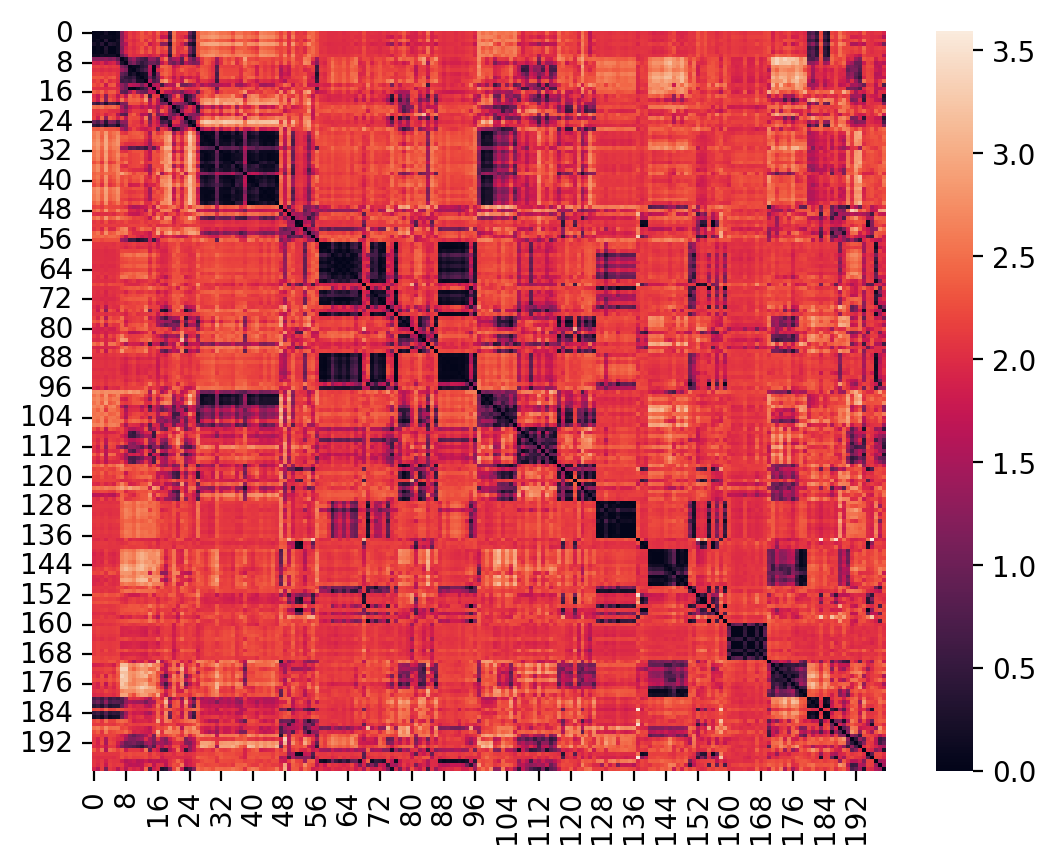

In [29]:
sns.heatmap(pairwise_distances_np(pred_val[900:1100]))

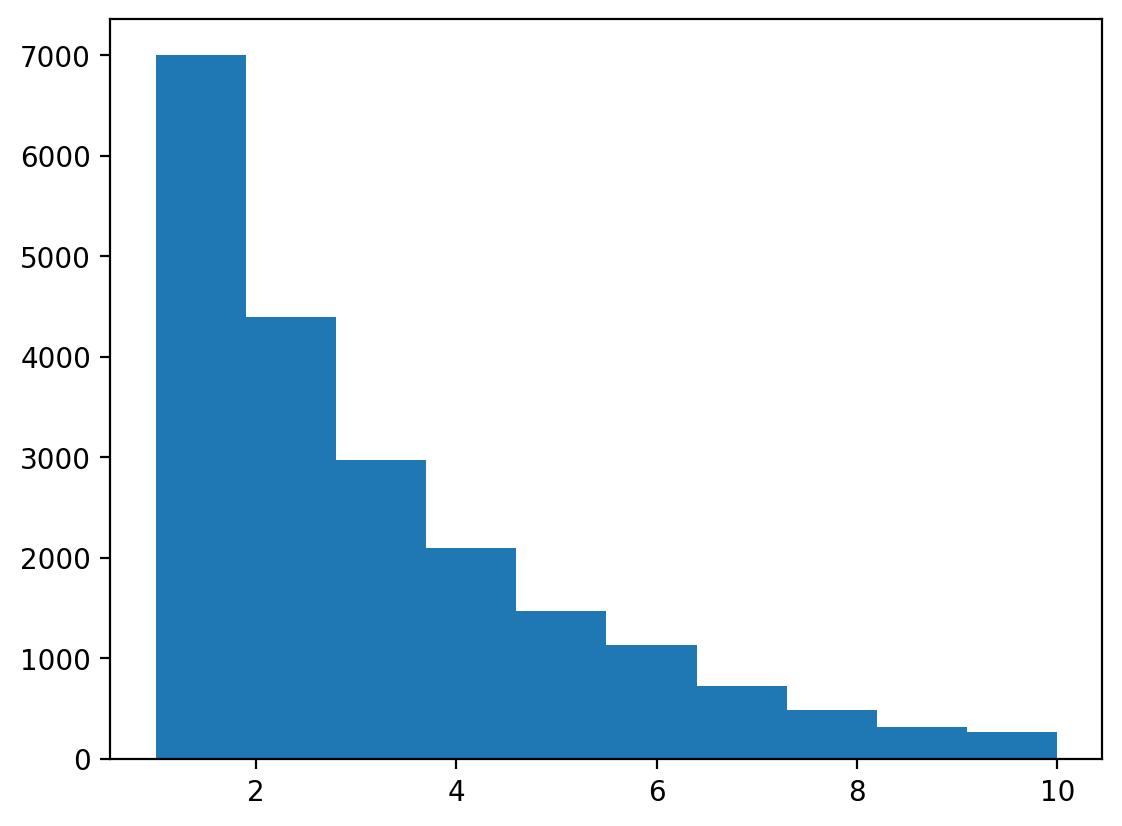

In [30]:
l = []
for k in neigh.keys():
    l.append(len([1 for x in neigh[k]["artists"] if x == neigh[k]["artistid"]]))
plt.hist(l)
plt.show();

In [31]:
val_df["subset"] = "0"
from collections import defaultdict

In [32]:
r = eval_submission(val_df, neigh)

In [33]:
r

{'0': 0.12466232185262247}

In [34]:
val_emb = {k: v for k,v in zip(val_df['trackid'].tolist(), pred_val)}
subm = get_ranked_list(embeds=val_emb, top_size=100, annoy_num_trees=256)
ev_sub(subm,val_df)

100% 20837/20837 [00:02<00:00, 8323.88it/s]
100% 20837/20837 [00:34<00:00, 595.65it/s]
100% 20837/20837 [00:06<00:00, 3273.62it/s]


0.12461648315940366

In [58]:
testgen = TestGenerator(test, cfg.img_size,1)

In [59]:
prediction = embedding_net.predict(testgen)

41377/41377 [==============================] - 110s 3ms/step


In [60]:
prediction.shape

(41377, 1024)

In [61]:
emb = {k: v for k,v in zip(test['trackid'].tolist(), prediction)}

In [62]:
subm = get_ranked_list(embeds=emb, top_size=100, annoy_num_trees=256)

100% 41377/41377 [00:09<00:00, 4222.41it/s]
100% 41377/41377 [02:34<00:00, 267.43it/s]


In [63]:
def save_submission(submission, submission_path):
    with open(submission_path, 'w') as f:
        for query_trackid, result in submission.items():
            f.write("{}\t{}\n".format(query_trackid, " ".join(map(str, result))))

In [64]:
save_submission(subm, os.path.join(mod_dir, 'submission.txt'))

In [ ]:
# subm

In [ ]:
results = embedding_net.predict(val_gen)

384/384 [==============================] - 11s 26ms/step


In [ ]:
results[0].shape

(1024,)

In [18]:
def load_img(path, img_size=(512, 81), default_img_size=(512, 81)):
    img = np.load(path).astype("float32")
    if img_size < default_img_size:
        wpad = (img.shape[1] - img_size[1]) // 2
        img = img[:, wpad : wpad + img_size[1]]
    if img.shape != img_size:
        wpad = img_size[1] - img.shape[1]
        wpad_l = wpad // 2
        wpad_r = wpad - wpad_l
        img = np.pad(
            img,
            pad_width=((0, 0), (wpad_l, wpad_r)),
            mode="constant",
            constant_values=0,
        )
    img = np.expand_dims(img, axis=-1)
    return img

In [25]:
labels = val_df["artistid"].tolist()
preds = np.zeros([val_df.shape[0], 1024])
batch = 64
# preds = []
for i in range(0, val_df.shape[0], batch):
    paths = val_df.loc[i : i + batch - 1, "path"]
    imgs = [load_img(path) for path in paths]
    imgs = np.array(imgs)
    # preds.append(embedding_net.predict(imgs))
    preds[i : i + batch] = embedding_net.predict(imgs)

2/2 [==============================] - 0s 16ms/step


In [26]:
# preds = np.array(preds)
preds.shape

(28021, 1024)

In [27]:
val_df.shape

(28021, 11)

In [ ]:
def pairwise_distance(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.
    output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
    feature: 2-D Tensor of size [number of data, feature dimension].
    squared: Boolean, whether or not to square the pairwise distances.
    Returns:
    pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    pairwise_distances_squared = math_ops.add(
        math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
        math_ops.reduce_sum(
            math_ops.square(array_ops.transpose(feature)), axis=[0], keepdims=True
        ),
    ) - 2.0 * math_ops.matmul(feature, array_ops.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
            pairwise_distances_squared
            + math_ops.cast(error_mask, dtypes.float32) * 1e-16
        )

    # Undo conditionally adding 1e-16.
    pairwise_distances = math_ops.multiply(
        pairwise_distances,
        math_ops.cast(math_ops.logical_not(error_mask), dtypes.float32),
    )

    num_data = array_ops.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
        array_ops.ones([num_data])
    )
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.python.framework import dtypes
from tensorflow.python.ops import array_ops, math_ops

with tf.device("/CPU:0"):
    dists = pairwise_distance(preds.astype("float32"))

In [28]:
from sklearn.metrics.pairwise import euclidean_distances

In [29]:
dists = euclidean_distances(preds)

In [30]:
def choose_100(
    dists,
    df,
):
    neigh = {}
    for ix in tqdm(range(dists.shape[0])):
        trackid = df.loc[ix, "trackid"]
        nearest_100 = np.argsort(dists[ix])[:101]
        tracks_100 = df.loc[nearest_100, "trackid"].tolist()
        neigh[trackid] = {
            "tracks": [x for x in tracks_100 if x != trackid],
            "atrtistid": df.loc[ix, "artistid"],
        }
        artist_100 = df.loc[nearest_100, "artistid"].tolist()
        neigh[trackid]["artists"] = artist_100

    return neigh

In [31]:
neigh = choose_100(dists, val_df)

100% 28021/28021 [01:16<00:00, 367.61it/s]


In [36]:
l = []
for k in neigh.keys():
    l.append(sum([1 for x in neigh[k]["artists"] if x == neigh[k]["atrtistid"]]))

(array([27911.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   110.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

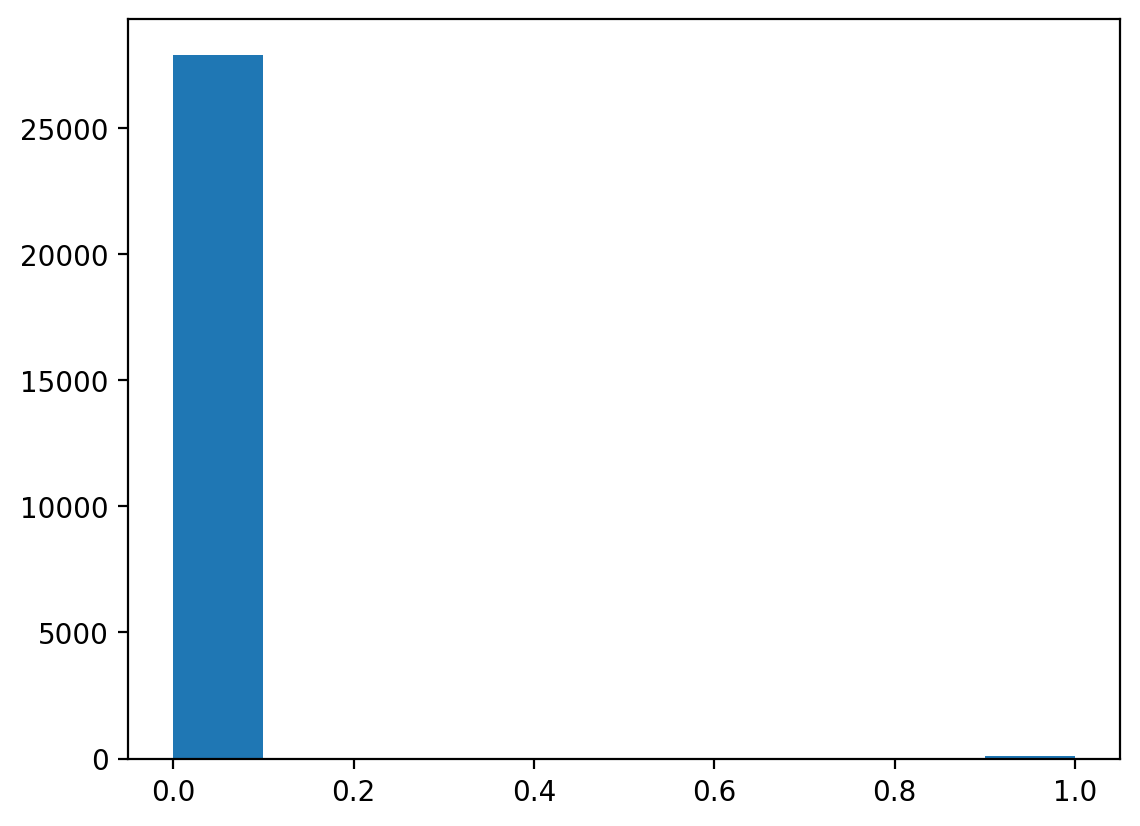

In [37]:
plt.hist(l)

In [31]:
# l

In [ ]:
# keras.utils.plot_model(
#     mod,
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
# )

In [ ]:
class DistanceLayer(keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = keras.layers.Input(name="anchor", shape=cfg.input_shape)
positive_input = keras.layers.Input(name="positive", shape=cfg.input_shape)
negative_input = keras.layers.Input(name="negative", shape=cfg.input_shape)

distances = DistanceLayer()(
    embedding_net(anchor_input),
    embedding_net(positive_input),
    embedding_net(negative_input),
)

siamese_network = keras.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
imgs, labels = train_gen._get_one(9, True)

In [ ]:
len(imgs)
labels

3

[0, 1]

In [ ]:
l, ps = train_gen.make_triplet(1)
l
ps
for p in ps:
    train.query("path == @p")[["artistid", "trackid"]]
l = [l[1], l[0]]
ps = [ps[0], ps[2], ps[1]]
ps
l

[1, 0]

['/app/_data/artist_data/train_features/8/9/1/95119.npy',
 '/app/_data/artist_data/train_features/8/5/7/158875.npy',
 '/app/_data/artist_data/train_features/6/0/1/102510.npy']

,artistid,trackid
107753,11338,95119


,artistid,trackid
107751,11338,158875


,artistid,trackid
49578,5196,102510


['/app/_data/artist_data/train_features/8/9/1/95119.npy',
 '/app/_data/artist_data/train_features/6/0/1/102510.npy',
 '/app/_data/artist_data/train_features/8/5/7/158875.npy']

[0, 1]

In [ ]:
train_gen = DataGenerator(
    data=train_data,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
    shuffle=True,
    positive_label=cfg.pos_label,
)
val_gen = DataGenerator(
    data=val_data,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
    shuffle=False,
    positive_label=cfg.pos_label,
)

In [ ]:
ix = np.random.randint(train_gen.__len__())
imgs, targets = train_gen.__getitem__(ix)

In [ ]:
imgs["img1"].shape

(32, 512, 81, 1)

In [ ]:
train_gen.positive_label
train_gen.negative_label

0

1

## Build model

In [ ]:
# model = make_model(
#     input_shape=cfg.input_shape,
#     n_blocks=cfg.n_blocks,
#     embedding_len=cfg.emb_len,
#     kernel_size=cfg.kernel_size,
#     activation_fn="relu",
#     batch_norm=cfg.batch_norm,
# )

In [ ]:
# base_model = keras.applications.EfficientNetV2B0(
#     include_top=False,
#     weights=None,
#     input_shape=cfg.input_shape,
#     pooling=None,
#     include_preprocessing=False,
# )
# input = tf.keras.Input(shape=cfg.input_shape, dtype="float32")
# x = base_model(input)
# x = keras.layers.Flatten(name="flatten")(x)
# x = keras.layers.Dense(
#     cfg.emb_len, activation=cfg.act_fn, name=f"dense_{cfg.emb_len}"
# )(x)
# embedding_net = keras.Model(inputs=input, outputs=x, name=f"embedding")

# input_1 = keras.layers.Input(cfg.input_shape, name="img1")
# input_2 = keras.layers.Input(cfg.input_shape, name="img2")
# node1 = embedding_net(input_1)
# node2 = embedding_net(input_2)

# merge_layer = keras.layers.Lambda(euclidean_distance)([node1, node2])
# output_layer = keras.layers.Dense(1, activation="sigmoid")(merge_layer)
# model = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
# model = effmod(input_shape=cfg.input_shape, embedding_len=cfg.emb_len)

In [ ]:
input = tf.keras.Input(shape=cfg.input_shape, dtype="float32")
x = keras.layers.Conv2D(
    4,
    cfg.kernel_size,
    activation=cfg.act_fn,
    name="Conv2D_1",
)(input)
x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_1")(x)

x = keras.layers.Conv2D(
    filters=16,
    kernel_size=cfg.kernel_size,
    activation=cfg.act_fn,
    name="Conv2D_2",
)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_2")(x)

x = keras.layers.Conv2D(
    filters=64,
    kernel_size=cfg.kernel_size,
    activation=cfg.act_fn,
    name="Conv2D_3",
)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_3")(x)

x = keras.layers.Conv2D(
    filters=256,
    kernel_size=cfg.kernel_size,
    activation=cfg.act_fn,
    name="Conv2D_4",
)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_4")(x)

# x = keras.layers.Conv2D(
#     filters=256,
#     kernel_size=cfg.kernel_size,
#     activation=cfg.act_fn,
#     name="Conv2D_5",
# )(x)
# x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_5")(x)


x = keras.layers.Flatten(name="flatten")(x)
x = keras.layers.Dense(cfg.emb_len, activation=cfg.act_fn, name=f"dense_{cfg.emb_len}")(
    x
)
embedding_net = keras.Model(inputs=input, outputs=x, name=f"embedding")


input_1 = keras.layers.Input(cfg.input_shape, name="img1")
input_2 = keras.layers.Input(cfg.input_shape, name="img2")
node1 = embedding_net(input_1)
node2 = embedding_net(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance)([node1, node2])
output_layer = keras.layers.Dense(1, activation="sigmoid")(merge_layer)
model = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
callbacks = make_callbacks(
    path=mod_dir,
    monitor="val_loss",
    mode="min",
    reduce_patience=10,
    stop_patience=100,
)
model.compile(
    loss=loss(1),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
)

In [ ]:
if os.path.exists(mod_dir):
    shutil.rmtree(mod_dir)
if os.path.exists(f"/app/.tensorboard/{mod_dir.split('/')[-2]}/"):
    shutil.rmtree(f"/app/.tensorboard/{mod_dir.split('/')[-2]}/")

In [ ]:
history = model.fit(
    x=train_gen,
    epochs=cfg.n_epochs,
    verbose="auto",
    callbacks=callbacks,
    validation_data=val_gen,
    shuffle=True,
    steps_per_epoch=len(train_data) // cfg.batch_size,
    validation_steps=len(val_data) // cfg.batch_size,
    validation_freq=1,
    max_queue_size=10,
    workers=10,
    use_multiprocessing=False,
)

Epoch 1/300
478/480 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.5865 - precision: 0.5478 - recall: 0.9611
Epoch 1: val_loss improved from inf to 0.21329, saving model to /app/_data/artist_data/models/test_arch/constr_10/model.h5
480/480 [==============================] - 45s 84ms/step - loss: 0.2248 - accuracy: 0.5870 - precision: 0.5481 - recall: 0.9610 - val_loss: 0.2133 - val_accuracy: 0.7139 - val_precision: 0.6564 - val_recall: 0.8985 - lr: 0.0010
Epoch 2/300
478/480 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.7069 - precision: 0.6543 - recall: 0.8857
Epoch 2: val_loss improved from 0.21329 to 0.19562, saving model to /app/_data/artist_data/models/test_arch/constr_10/model.h5
480/480 [==============================] - 40s 83ms/step - loss: 0.2028 - accuracy: 0.7069 - precision: 0.6544 - recall: 0.8860 - val_loss: 0.1956 - val_accuracy: 0.7106 - val_precision: 0.6513 - val_recall: 0.9139 - lr: 0.0010
Epoch 3/300
479/480 [=====

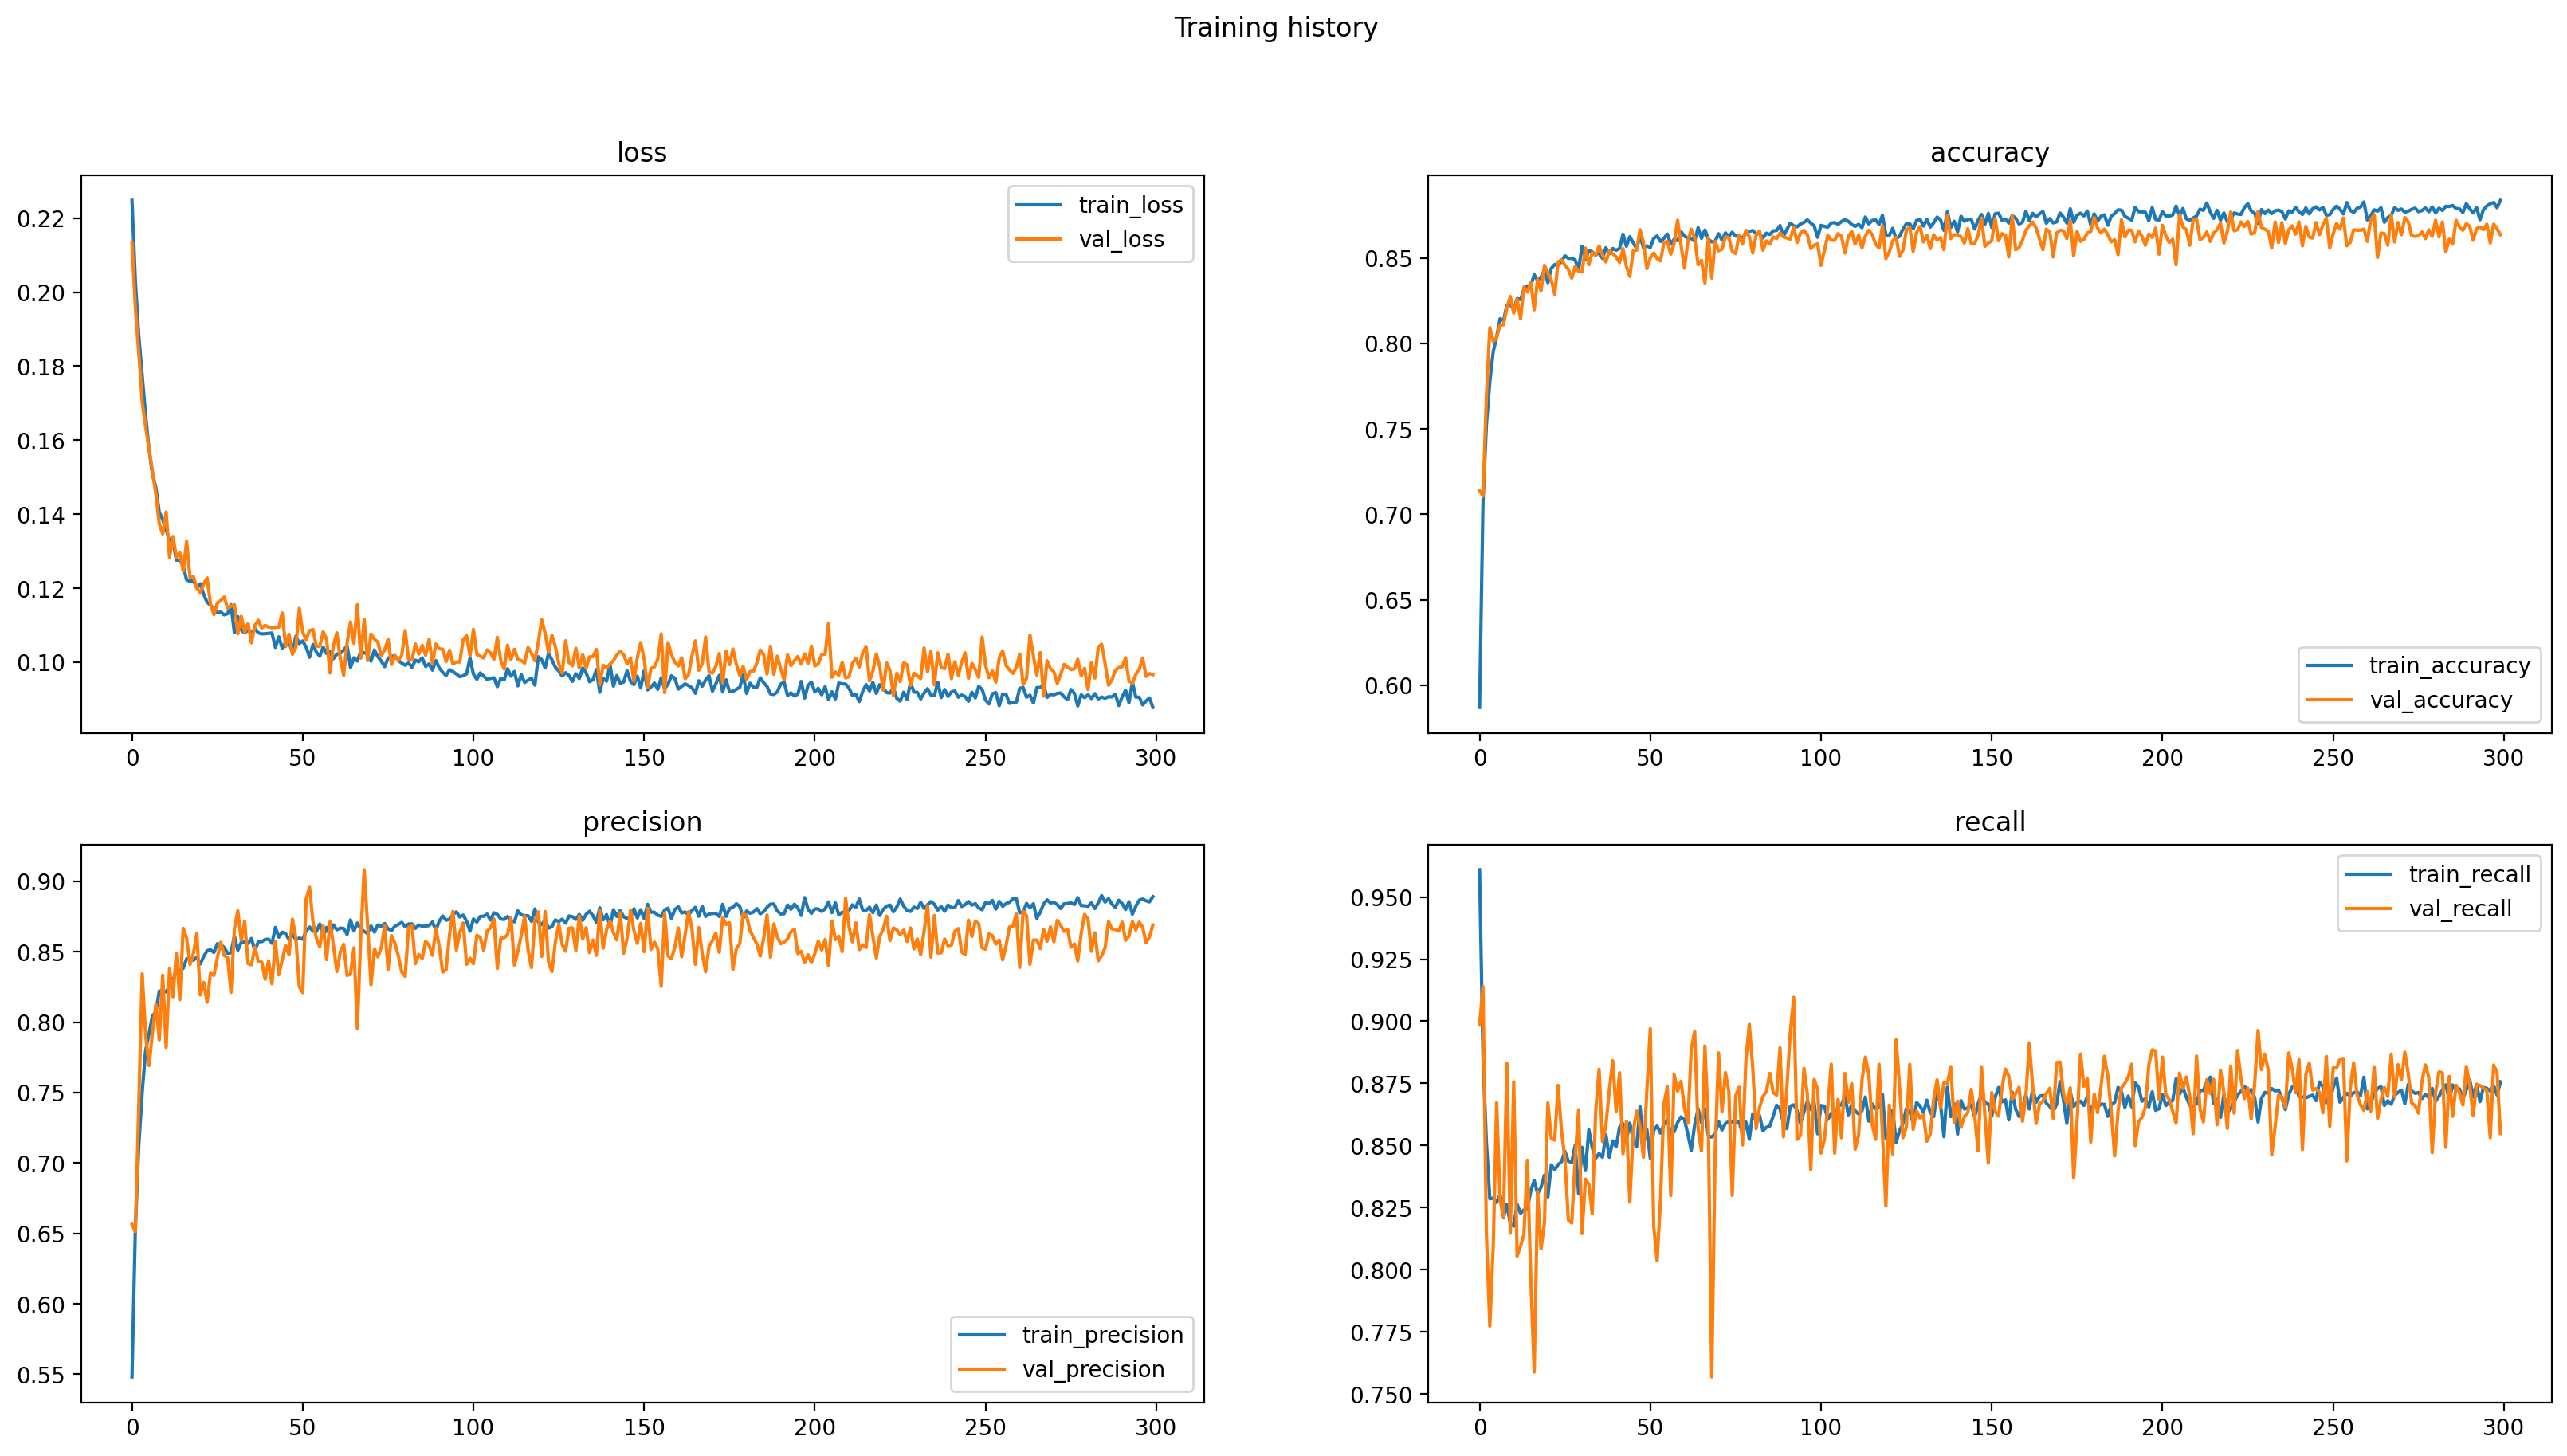

In [ ]:
plot_history(history.history)

## save

In [ ]:
def save_params(mod_dir, model, history, cfg, loss="constr"):
    train_history = history.history
    min_val_loss_ix = np.argmin(train_history["val_loss"])
    max_acc = train_history["val_accuracy"][min_val_loss_ix]
    max_acc = int(np.round(max_acc * 1000))
    for k in train_history.keys():
        train_history[k] = list(map(float, train_history[k]))
    model.save(
        os.path.join(mod_dir, f"model_{max_acc}.h5"),
    )
    config = {
        "loss": loss,
        "pos_label": cfg.pos_label,
        "history": train_history,
        "norm": cfg.norm,
        "fold": cfg.fold,
        "model": {
            "eff": False,
            "input_shape": cfg.input_shape,
            "n_blocks": cfg.n_blocks,
            "embedding_len": cfg.emb_len,
            "kernel_size": cfg.kernel_size,
            "activation_fn": cfg.act_fn,
            "batch_norm": False,
        },
    }
    with open(os.path.join(mod_dir, "config.json"), "w") as f:
        json.dump(config, f)
    model.save(os.path.join(mod_dir, f"model_{max_acc}"), include_optimizer=False)
    print(
        f'Max_acc = {max_acc/1000}, model saved to {os.path.join(mod_dir, f"model_{max_acc}")}'
    )

In [ ]:
save_params(mod_dir, model, history, cfg, loss="constr")

INFO:tensorflow:Assets written to: /app/_data/artist_data/models/test_arch/constr_10/model_875/assets


INFO:tensorflow:Assets written to: /app/_data/artist_data/models/test_arch/constr_10/model_875/assets


Max_acc = 0.875, model saved to /app/_data/artist_data/models/test_arch/constr_10/model_875
